<h2>Support Vector Machine</h2>

In this module, we learn to use Support Vector Machine to solve classification and regression problems

<h3>Linear Support Vector Machine for Binary Classification</h3>

We start with the simplest case: linear SVM for binary classification. Let's simulate a simple dataset with two features so we can visualize the model.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
#create some instances 
X = np.array([
    [1,1],
    [1.5,2],
    [2,1],
    [1.41,1.41],
    [1,2],
    [1,3],
    [3,3],
    [3,5],
    [3.5,2],
    [3.6,3.2],
    [3.1,3.5],
    [2.5,4]
])

Y = np.array([0,0,0,0,0,0,1,1,1,1,1,1])

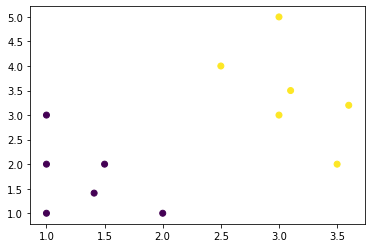

In [3]:
#and visualize them
#colors will represent the two classes in this case
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

In [4]:
#now fit a linear SVM
from sklearn.svm import LinearSVC

lsvc = LinearSVC()
lsvc.fit(X,Y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

We can also obtain the intercept and coefficients with intercept_ and coef_

In [5]:
lsvc.intercept_

array([-1.83050523])

In [6]:
lsvc.coef_

array([[0.63129273, 0.20026849]])

So the hyperplane (in this case, the line) has the equation

$-1.8305 + 0.6313x_1 + 0.2003x_2$

We can also visualize it (just for demonstration, I won't ask you to do this, your data will have more than two features anyway)

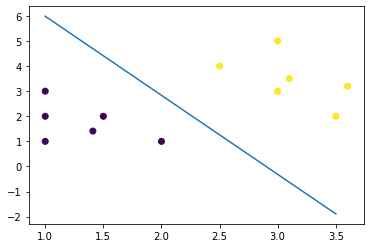

In [29]:
x1 = np.linspace(1,3.5,100)
x2 = (- lsvc.intercept_ - lsvc.coef_[0,0]*x1)/lsvc.coef_[0,1]

plt.scatter(X[:,0], X[:,1], c=Y)
plt.plot(x1,x2)
plt.show()

The line doesn't look too optimal, this is due to the regularization term C. We can use very high C to minimize the effect of regularization:

c:\users\linhl\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


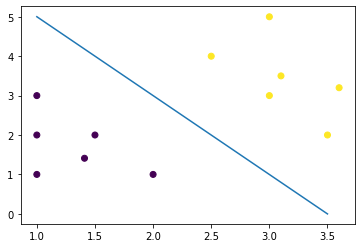

In [7]:
lsvc = LinearSVC(C=1000, max_iter=5000)
lsvc.fit(X,Y)

x1 = np.linspace(1,3.5,100)
x2 = (- lsvc.intercept_ - lsvc.coef_[0,0]*x1)/lsvc.coef_[0,1]

plt.scatter(X[:,0], X[:,1], c=Y)
plt.plot(x1,x2)
plt.show()

And the line seems to be in the middle of the two classes now. Note that the use of high C here is just for demonstration, and I want to show the non-regularized SVM. In reality, data is not as nicely separated, and we need to finetune C.

<h4>Real Example</h4>

After the toy example, let return to a real dataset: the credit approval data (crx.data) and test LinearSVC there. The next cell will just repead all the preprocessing steps we did like in other modules, but without log transformation.

In [8]:
crx = pd.read_csv('crx.data', header=None)
crx.head()

Y = np.zeros(crx.shape[0])           #create a vector of zeros with size = the data
Y[crx[15]=='+'] = 1                  #when the actual target is +, Y is assigned 1
crx[15] = Y  

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in split.split(crx, crx[15]):
    strat_train_set = crx.loc[train_index]
    strat_test_set = crx.loc[test_index]
    
trainX = strat_train_set.loc[:,:14]
trainY = strat_train_set.loc[:,15]
trainX.shape, trainY.shape

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

num_cols = trainX.columns[(trainX.dtypes == np.int64) | (trainX.dtypes == np.float64)]

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('standardize', StandardScaler())
])

from sklearn.preprocessing import OneHotEncoder

#get a list of class columns
cat_cols = trainX.columns[trainX.dtypes==object]

cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant',fill_value='missing')),
    ('encode', OneHotEncoder())
])

from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
    ('numeric', num_pipeline, num_cols),
    ('class', cat_pipeline, cat_cols)
])

trainX_prc = full_pipeline.fit_transform(trainX)

testX = strat_test_set.loc[:,:14]
testY = strat_test_set.loc[:,15]

testX_prc = full_pipeline.transform(testX)  

Now we can try the LinearSVC. I will finetune it directly with GridSearchCV. First, l2 regularization:

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = [{
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}]

lsvc = LinearSVC(max_iter=5000)

grid_search = GridSearchCV(lsvc, param_grid, cv=5, scoring='accuracy', return_train_score=True)

grid_search.fit(trainX_prc,trainY)

c:\users\linhl\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=5000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

Best training model:

In [51]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 0.01}
0.8528752800597461


In [52]:
best_l2_lsvc = grid_search.best_estimator_
best_l2_lsvc.score(testX_prc, testY)

0.8728323699421965

Then l1 regularization. We need to add dual=False in this case.

In [56]:
lsvc = LinearSVC(penalty='l1', dual=False, max_iter=5000)

grid_search = GridSearchCV(lsvc, param_grid, cv=5, scoring='accuracy', return_train_score=True)

grid_search.fit(trainX_prc,trainY)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=5000,
                                 multi_class='ovr', penalty='l1',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [57]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 1}
0.8509335324869305


In [58]:
best_l1_lsvc = grid_search.best_estimator_
best_l1_lsvc.score(testX_prc, testY)

0.861271676300578

<h3> Using Kernel SVM </h3>

Now we will try kernel SVM on the credit approval data. We will directly finetune the model (without fitting the default model). We can actually specify all hyperparameters in one grid search (including the kernel functions).

One note is that SVM is relatively complicated, so if you specify too many hyperparameter values, the gridsearch will run for a long time.

In [10]:
from sklearn.svm import SVC

svc = SVC()

param_grid = [{
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel' : ['poly','rbf'],
    'coef0' : [-1, -0.1, 0, 0.1, 1],
    'degree' : [2, 3],
    'gamma' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}]

grid_search = GridSearchCV(svc, param_grid, cv=3, scoring='accuracy', return_train_score=True)

grid_search.fit(trainX_prc,trainY)

GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'coef0': [-1, -0.1, 0, 0.1, 1], 'degree': [2, 3],
                          'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'kernel': ['poly', 'rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

Let's check the best model

In [71]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 0.1, 'coef0': 0.1, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}
0.8722834610386702


And test it on testing data

In [72]:
best_svc = grid_search.best_estimator_
best_svc.score(testX_prc, testY)

0.8670520231213873

<h4>Summarize all Results</h4>

I will also include Logistic regression

|Model|Training CV Accuracy| Testing Accuracy|
|-----|--------------------|-----------------|
|No Regularization|0.834|0.850|
|L2 Regularization|0.857|0.861|
|L1 Regularization|0.861|0.861|
|ENet Regularization|0.863|0.861|
|L1 Linear SVM|0.851|0.861|
|L2 Linear SVM|0.853|0.873|
|Kernel SVM|0.872|0.867|

We can see that except for L1 LSVM, both L2 LSVM and Kernel SVM are slightly better than Logistic regression. Kernel SVM also has very good and consistent performance in both training CV and testing

<h3>SVM for Multilabel Classification</h3>

We will use the wine quality data again. The cell below does all the preprocessing steps we did in the previous module without the log transformation

In [12]:
wine = pd.read_csv('winequality-red.csv',sep=';')
wine.head()

wine["quality_cat"] = pd.cut(wine["quality"],              #the column to use for labeling
                             bins=[0, 5, 6, np.inf],  #the ranges of the labels
                             labels=[1, 2, 3]) 
wine['quality_cat'].value_counts()

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in split.split(wine, wine['quality']):
    strat_train_set = wine.loc[train_index]
    strat_test_set = wine.loc[test_index]
    
trainX = strat_train_set.iloc[:,:-2]                   #since index -2 is the original quality, we exclude it from trainX
trainY = strat_train_set.iloc[:,-1]                    #and trainY is index -1 which is quality_cat
testX = strat_test_set.iloc[:,:-2]
testY = strat_test_set.iloc[:,-1]
trainX.shape, trainY.shape, testX.shape, testY.shape

num_pipeline = Pipeline([
    ('standardize', StandardScaler())
])

trainX_prc = num_pipeline.fit_transform(trainX)
testX_prc = num_pipeline.transform(testX)

And fit the SVM. I will not fit linear SVM anymore. Also, Polynomial kernel is very expensive to train, so I will just fit RBF kernel. In practice, RBF kernel is the most common type of kernel for SVM.

In [13]:
svc = SVC()

param_grid = [{
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel' : ['rbf'],
    'gamma' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}]

grid_search = GridSearchCV(svc, param_grid, cv=3, scoring='accuracy', return_train_score=True)

grid_search.fit(trainX_prc,trainY)

GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

The best model is

In [14]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.6563784461152883


And applied to the testing data

In [15]:
best_svc = grid_search.best_estimator_
best_svc.score(testX_prc, testY)

0.6475

<h4>Result Summary</h4>

Compare to Logistic regression and SoftMax regression:

|Model|Training CV Accuracy| Testing Accuracy|
|-----|--------------------|-----------------|
|L2 Logistic|0.6389|0.6325|
|L1 Logistic|0.6280|0.6425|
|ENet Logistic|0.6414|0.6300|
|L2 SoftMax|0.6389|0.6325|
|L1 SoftMax|0.6397|0.6375|
|ENet SoftMax|0.6414|0.63|
|Kernel SVM|0.6564|0.6475|

You can see that kernel SVM outperforms all other models in both training and testing performance. We also don't need to worry about creating new features like in linear models :)

<h3> Support Vector Regressor </h3>

SVM can be modified to work on regression problem. We call this model Support Vector Regressor (SVR). In SKLearn, fitting SVR is pretty much identical to fitting SVC (except for target must be continuous). All hyperparameters of SVR are the same as SVC.

In the below example, we use the auto-mpg data - predicting miles-per-gallon of cars using their other features

First, import and preprocessing data:

In [16]:
auto = pd.read_csv('auto-mpg.csv')

from sklearn.model_selection import ShuffleSplit

split = ShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in split.split(auto):
    train_set = auto.loc[train_index]
    test_set = auto.loc[test_index]
    
trainX = train_set.drop('mpg',axis=1)
trainY = train_set['mpg']
testX = test_set.drop('mpg',axis=1)
testY = test_set['mpg']

trainX.shape, testX.shape, trainY.shape, testY.shape

((298, 7), (100, 7), (298,), (100,))

In [17]:
#pipeline for numeric features
#we need to impute horsepower
num_cols = trainX.columns[:-1] #because the last column is class
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('standardize', StandardScaler())
])

#pipeline for class features
cat_cols = trainX.columns[-1:] #because the last column is class
cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

#full pipeline - combine numeric and class pipelines
full_pipeline = ColumnTransformer([
    ('numeric', num_pipeline, num_cols),
    ('class', cat_pipeline, cat_cols)
])

trainX_prc = full_pipeline.fit_transform(trainX)
testX_prc = full_pipeline.transform(testX)

Now we finetune a SVR. You can see it is very similar to the kernel SVC we used before. For the same reason as before, I won't try Polynomial kernel.

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

svr = SVR()

param_grid = [{
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel' : ['rbf'],
    'gamma' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}]

grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='r2', return_train_score=True)

grid_search.fit(trainX_prc,trainY)

GridSearchCV(cv=3, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=0)

The finetuned model (note that score is now R2 since we are doing regression):

In [19]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.8641016605334603


And the testing performance 

In [20]:
best_svr = grid_search.best_estimator_
best_svr.score(testX_prc, testY)

0.9050367149992335

<h4> Result Summary </h4>

We can compare SVR performance to the other three:

|Model|Training CV R2| Testing R2|
|-----|--------------|-----------|
|Ridge|0.852         |0.893      |
|LASSO|0.851         |0.895      |
|ENet |0.851         |0.895      |
|SVR  |0.864         |0.905      |

Once again, SVR outperforms all linear models without the needs of engineering polynomial features. 

<h4> Some Notes</h4>

In general, SVM is very powerful, however is quite a bit more complex than some other models (especially linear ones). You should always try SVM if you can, however, SVM is not recommended for data of over 10,000 instances unless you have a very powerful training system, or a lot of time to spend.